In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
start_date = '2020-01-01'
end_date = '2023-12-1'


# Split the data into training and test sets
df_tsla = yf.download("RIVN", start_date , end_date)['Close']

# Calculate the split point
split_index = int(len(df_tsla) * 0.8)
train_df_tsla = df_tsla[:split_index]
test_df_tsla = df_tsla[split_index:]

# Print the number of data points in each set
print("Training set size:", len(train_df_tsla))
print("Test set size:", len(test_df_tsla))

[*********************100%%**********************]  1 of 1 completed
Training set size: 413
Test set size: 104


In [3]:
# Calculate the difference and remove NaN values
log_train_df_tsla = np.log(np.log(train_df_tsla))
diff_train_df_tsla = train_df_tsla.diff().dropna()

diff_test_df_tsla = test_df_tsla.diff().dropna()

### Visualize Tesla Share Price

In [4]:
def plot_share_price(series):
    plt.figure(figsize=(12,4))
    series.plot()
    plt.grid()
    plt.ylabel("Price")
    plt.title("RIVN Share Price", fontsize = 14)
    plt.show()

In [5]:
def plot_returns_distributions(series):

    # Calculate daily, weekly, and monthly returns
    daily_returns = series.pct_change().dropna()
    weekly_returns = series.resample('W').ffill().pct_change().dropna()
    monthly_returns = series.resample('M').ffill().pct_change().dropna()

    # Create a 1x3 subplot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot the distribution of daily returns
    sns.histplot(daily_returns, bins=30, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title('Daily Returns')
    axes[0].set_xlabel('Daily Returns')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # Plot the distribution of weekly returns
    sns.histplot(weekly_returns, bins=30, kde=True, color='green', ax=axes[1])
    axes[1].set_title('Weekly Returns')
    axes[1].set_xlabel('Weekly Returns')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)

    # Plot the distribution of monthly returns
    sns.histplot(monthly_returns, bins=30, kde=True, color='orange', ax=axes[2])
    axes[2].set_title('Monthly Returns')
    axes[2].set_xlabel('Monthly Returns')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

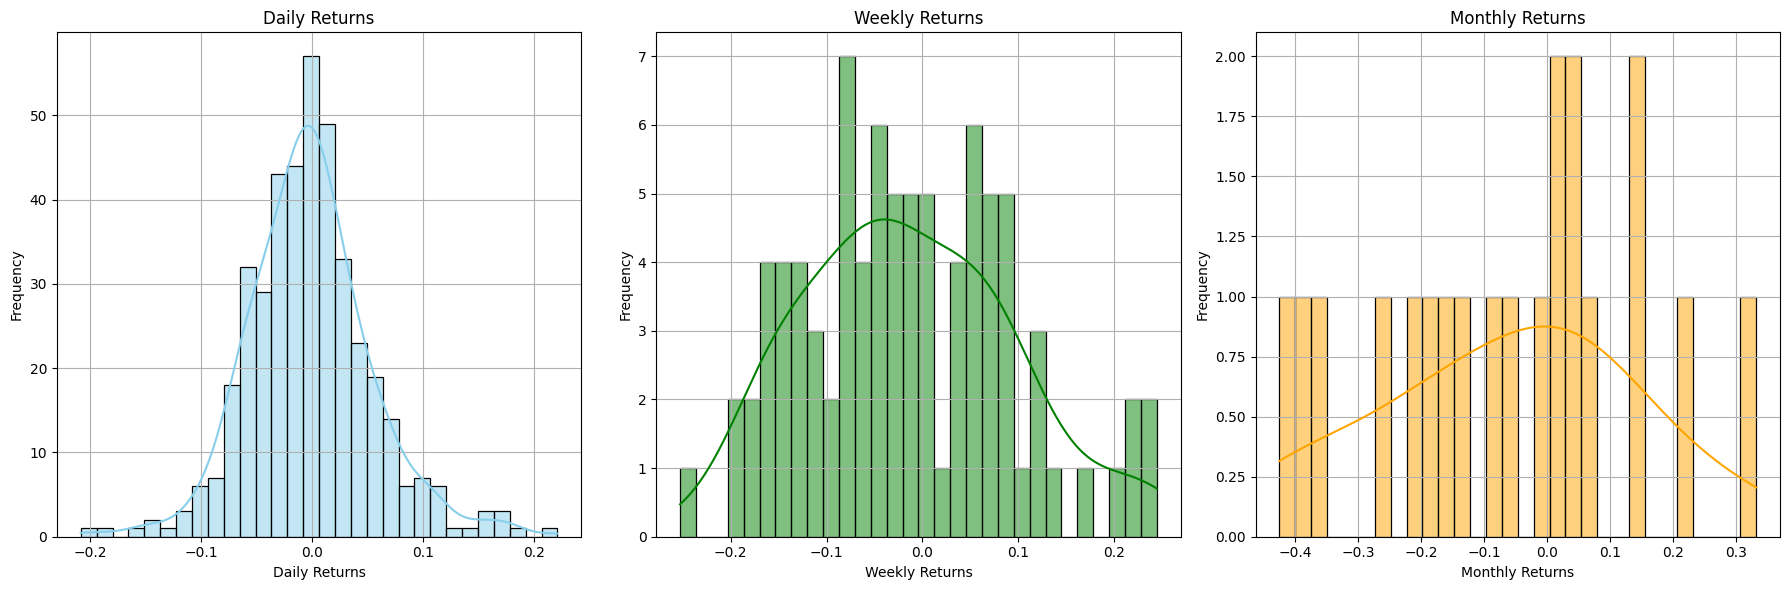

In [6]:
plot_returns_distributions(train_df_tsla)

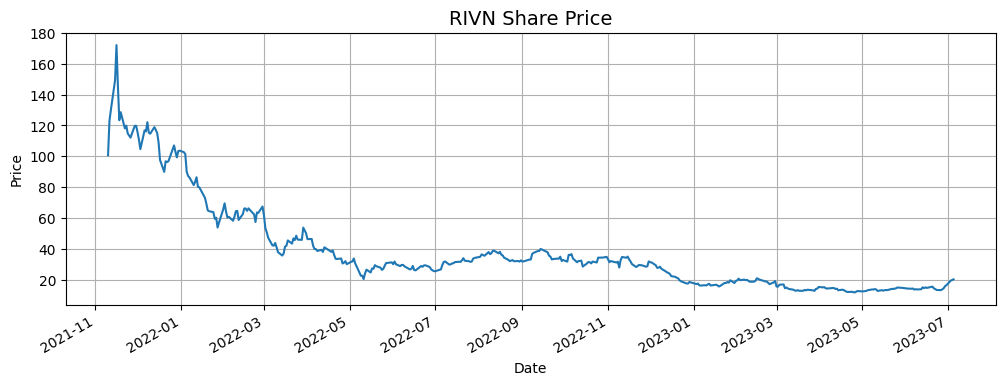

In [7]:
plot_share_price(train_df_tsla)

### Augmented Dickey–Fuller test

In [8]:
def adf_test(series):

    # Perform Augmented Dickey-Fuller test
    result = adfuller(series.values, autolag='AIC')

    # Print the results
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [9]:
adf_test(train_df_tsla)

ADF Statistic: -4.710395
p-value: 0.000080
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


The test statistic is positive, meaning we are much less likely to reject the null hypothesis (it looks non-stationary).

Comparing the test statistic to the critical values, it looks like we would have to fail to reject the null hypothesis that the time series is non-stationary and does have time-dependent structure.

In [10]:
adf_test(np.log(train_df_tsla))

ADF Statistic: -1.767950
p-value: 0.396486
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


In [11]:
adf_test(train_df_tsla.diff().dropna())

ADF Statistic: -4.136389
p-value: 0.000843
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


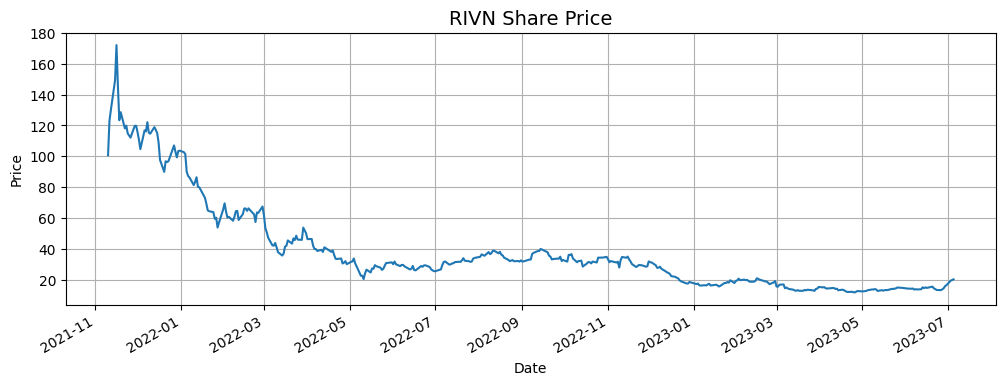

In [12]:
plot_share_price(train_df_tsla)

### ARIMA Model

In [13]:
def plot_diagnosticsTight(data, rtn, title1 = 'TSLA'):

    fig, axes = plt.subplots(1,2,figsize=(15,5))
    axes[0].set_ylabel('ACF', fontsize=15)
    axes[0].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(data,lags=25,zero=True, ax = axes[0], title= 'ACF '+ title1, use_vlines = True)
    axes[1].set_ylabel('ACF', fontsize=15)
    axes[1].set_xlabel('Lag', fontsize=15)
    fig = plot_acf(rtn,lags=25,zero=True, ax = axes[1], title= 'ACF Log '+ title1, use_vlines = True)
    plt.tight_layout()

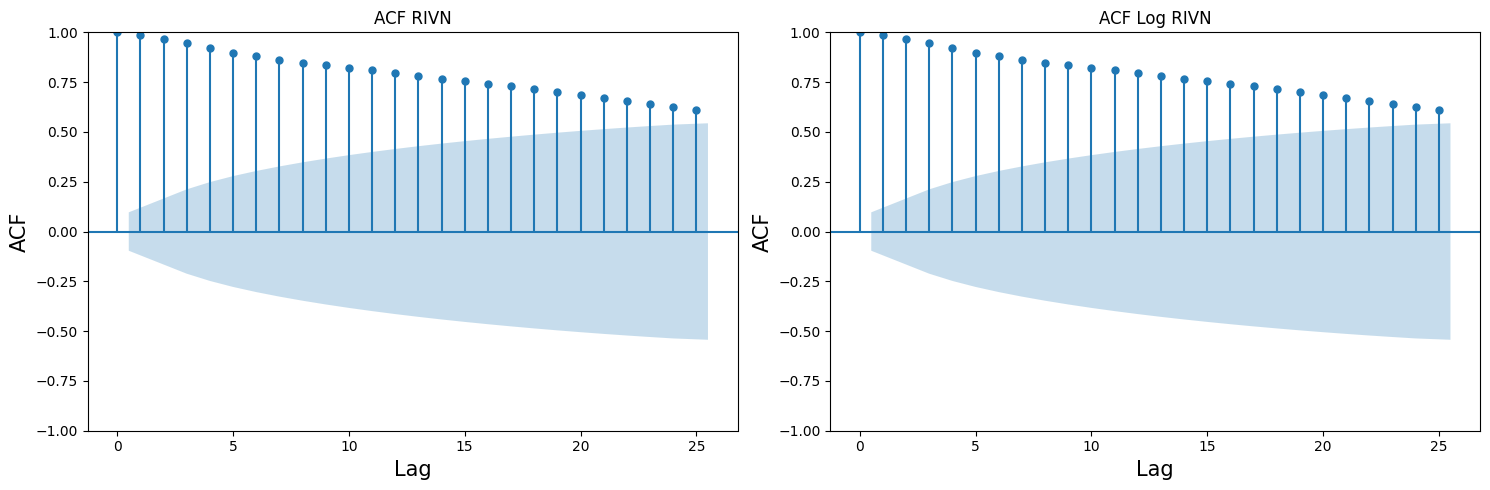

In [14]:
plot_diagnosticsTight(train_df_tsla, train_df_tsla, title1 = 'RIVN')

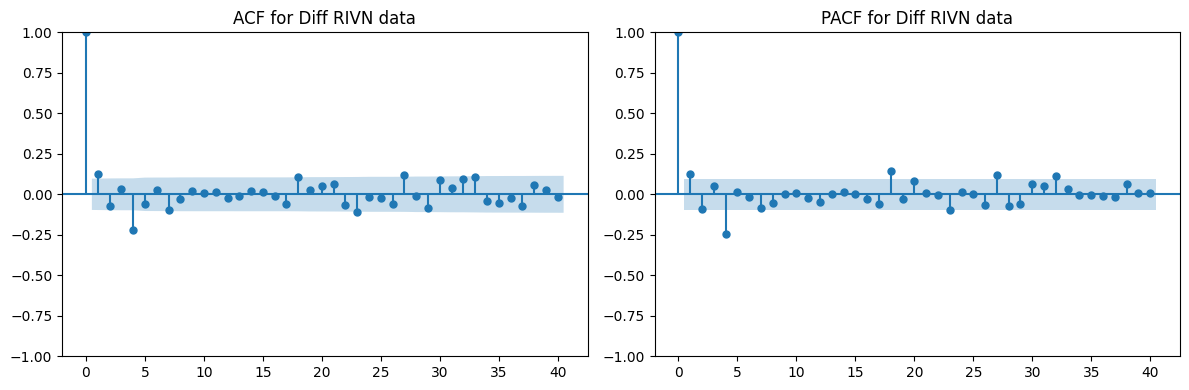

In [15]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF plot
sm.graphics.tsa.plot_acf(diff_train_df_tsla, lags=40, ax=ax1)
ax1.set_title('ACF for Diff RIVN data')

# PACF plot
sm.graphics.tsa.plot_pacf(diff_train_df_tsla, lags=40, ax=ax2)
ax2.set_title('PACF for Diff RIVN data')

plt.tight_layout()
plt.show()

In [16]:
def search_arma_model(data, max_p, max_q):
    aic_values = []
    bic_values = []

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            model = sm.tsa.ARIMA(data.values, order=(p, 0, q))  # For ARMA, set d=0
            results = model.fit()
            aic = results.aic
            bic = results.bic
            aic_values.append(aic)
            bic_values.append(bic)

            print(f"p: {p}  q: {q}  aic: {aic}  bic: {bic}")

    return aic_values, bic_values

In [17]:
# Call the function with your data and maximum values for p and q
aic_values, bic_values = search_arma_model(train_df_tsla, max_p=6, max_q=3)

p: 0  q: 0  aic: 3957.808967967804  bic: 3965.855863153726
p: 0  q: 1  aic: 3428.732826374457  bic: 3440.80316915334


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 0  q: 2  aic: 3069.653704729076  bic: 3085.74749510092


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 0  q: 3  aic: 2833.400356577583  bic: 2853.517594542388
p: 1  q: 0  aic: 2225.824851600947  bic: 2237.89519437983
p: 1  q: 1  aic: 2217.8995557669464  bic: 2233.9933461387905
p: 1  q: 2  aic: 2213.5906821762574  bic: 2233.7079201410625
p: 1  q: 3  aic: 2211.2556852819907  bic: 2235.396370839757
p: 2  q: 0  aic: 2219.725801409001  bic: 2235.8195917808453
p: 2  q: 1  aic: 2208.4699584477053  bic: 2228.5871964125104
p: 2  q: 2  aic: 2210.351352709113  bic: 2234.4920382668793
p: 2  q: 3  aic: 2210.5532468749498  bic: 2238.717380025677
p: 3  q: 0  aic: 2219.1248880850917  bic: 2239.242126049897
p: 3  q: 1  aic: 2210.3145858446933  bic: 2234.4552714024594


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3  q: 2  aic: 2208.462373311365  bic: 2236.626506462092


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3  q: 3  aic: 2197.728193409229  bic: 2229.915774152917
p: 4  q: 0  aic: 2218.3069573263197  bic: 2242.447642884086
p: 4  q: 1  aic: 2209.9198963602516  bic: 2238.084029510979


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4  q: 2  aic: 2205.6122770924667  bic: 2237.799857836155


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4  q: 3  aic: 2203.297268611831  bic: 2239.50829694848
p: 5  q: 0  aic: 2191.000164012206  bic: 2219.164297162933
p: 5  q: 1  aic: 2192.9753808456926  bic: 2225.1629615893808
p: 5  q: 2  aic: 2193.3087602193846  bic: 2229.5197885560337


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 5  q: 3  aic: 2193.580847648827  bic: 2233.815323578437
p: 6  q: 0  aic: 2192.9718792124086  bic: 2225.1594599560967
p: 6  q: 1  aic: 2194.164489356466  bic: 2230.3755176931154
p: 6  q: 2  aic: 2194.7302375928225  bic: 2234.9647135224327
p: 6  q: 3  aic: 2197.2120816964416  bic: 2241.470005219013


C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


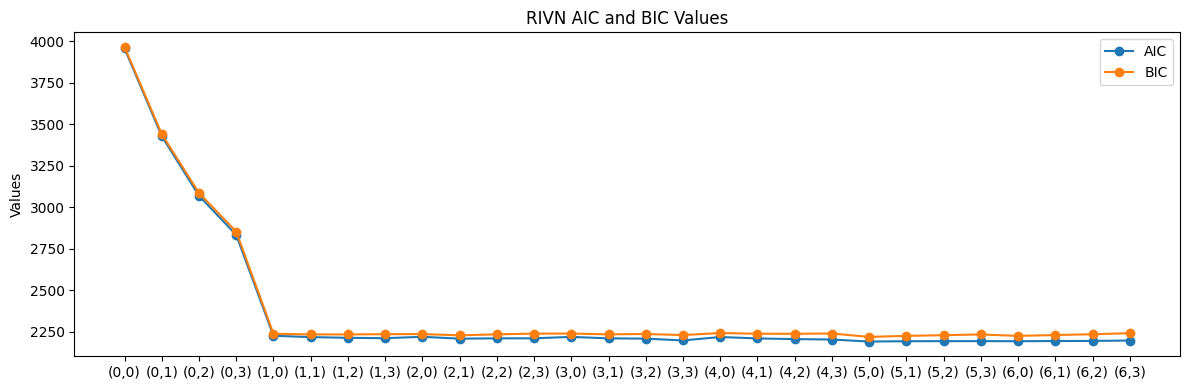

In [18]:
# Define max_p and max_q
max_p = 6
max_q = 3

# Visualize AIC and BIC values in one chart
p_values = range(max_p + 1)
q_values = range(max_q + 1)

fig, ax = plt.subplots(figsize=(12, 4))
tick_labels = []

ax.plot(aic_values, marker='o', label='AIC')
ax.plot(bic_values, marker='o', label='BIC')
ax.set_xticks(range(len(aic_values)))
for p in p_values:
    for q in q_values:
        tick_labels.append(f'({p},{q})')
ax.set_xticklabels(tick_labels)
ax.set_ylabel('Values')
ax.set_title('RIVN AIC and BIC Values')
ax.legend()

plt.tight_layout()
plt.show()

In [19]:
# Number of days to use for the rolling window
window_size = 10

# Create an empty list to store the predictions
train_predictions = []

# Iterate over the dataset using a rolling window
for t in range(window_size, len(train_df_tsla)):
    # Select the current rolling window of data
    current_window = train_df_tsla.values[t - window_size : t]

    # Fit the ARIMA model for the current window
    model = sm.tsa.ARIMA(current_window, order=(1, 0, 0))
    model_fit = model.fit()

    # Forecast the next day's value
    forecasted_value = model_fit.forecast(steps=1)

    # Append the forecasted value to the list of predictions
    train_predictions.append(forecasted_value[0])

C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\12134\anaconda3\envs\financial_project\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
# Calculate MSPE
mse = mean_squared_error(train_df_tsla.values[window_size:], train_predictions)
rmse = np.sqrt(mse)


# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2.863441402933257


In [21]:
# Create an empty list to store the predictions
test_predictions = []

# Iterate over the dataset using a rolling window
for t in range(window_size, len(diff_test_df_tsla)):
    # Select the current rolling window of data
    current_window = diff_test_df_tsla.values[t - window_size : t]

    # Fit the ARIMA model for the current window
    model = sm.tsa.ARIMA(current_window, order=(1, 0, 0))
    model_fit = model.fit()

    # Forecast the next day's value
    forecasted_value = model_fit.forecast(steps=1)

    # Append the forecasted value to the list of predictions
    test_predictions.append(forecasted_value[0])

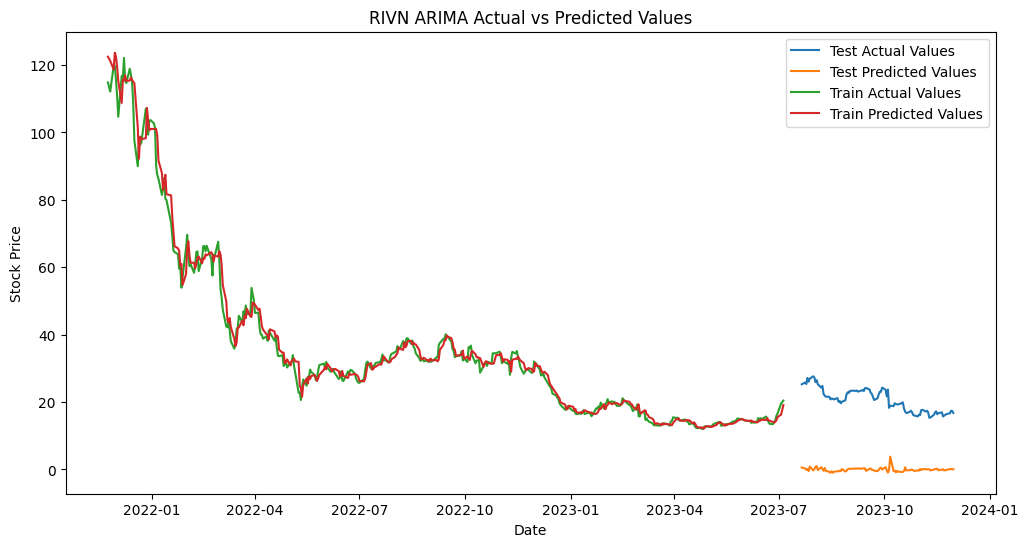

Root Mean Squared Error (RMSE): 20.95304923521946


In [22]:
# Convert the differenced predictions to actual values
predicted_values = test_predictions

# Calculate MSPE
mse = mean_squared_error(test_df_tsla.values[window_size+1:], predicted_values)
rmse = np.sqrt(mse)

# Visualize actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_df_tsla.index[window_size+1:], test_df_tsla.values[window_size+1:], label='Test Actual Values')
plt.plot(test_df_tsla.index[window_size+1:], predicted_values, label='Test Predicted Values')
plt.plot(train_df_tsla.index[window_size:], train_df_tsla.values[window_size:], label='Train Actual Values')
plt.plot(train_df_tsla.index[window_size:], train_predictions, label='Train Predicted Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('RIVN ARIMA Actual vs Predicted Values')
plt.legend()
plt.show()

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

### ARIMA Model Residule Analysis

## LSTM Model

In [23]:
dataset = df_tsla.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [24]:
training_data_len = int(np.ceil( len(dataset) * .8 ))

In [25]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [26]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
history = model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)



Epoch 1/100

2/2 - 2s - loss: 0.0800 - 2s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.0769 - 12ms/epoch - 6ms/step
Epoch 3/100
2/2 - 0s - loss: 0.0741 - 10ms/epoch - 5ms/step
Epoch 4/100
2/2 - 0s - loss: 0.0713 - 11ms/epoch - 5ms/step
Epoch 5/100
2/2 - 0s - loss: 0.0688 - 12ms/epoch - 6ms/step
Epoch 6/100
2/2 - 0s - loss: 0.0661 - 11ms/epoch - 6ms/step
Epoch 7/100
2/2 - 0s - loss: 0.0637 - 10ms/epoch - 5ms/step
Epoch 8/100
2/2 - 0s - loss: 0.0614 - 10ms/epoch - 5ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0592 - 11ms/epoch - 6ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0571 - 11ms/epoch - 5ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0553 - 10ms/epoch - 5ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0534 - 10ms/epoch - 5ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0515 - 10ms/epoch - 5ms/step
Epoch 14/100
2/2 - 0s - loss: 0.0499 - 11ms/epoch - 6ms/step
Epoch 15/100
2/2 - 0s - loss: 0.0484 - 10ms/epoch - 5ms/step
Epoch 16/100
2/2 - 0s - loss: 0.0469 - 11ms/epoch - 6ms/step
Epoch 17/100
2/2 - 0s - loss: 0.0

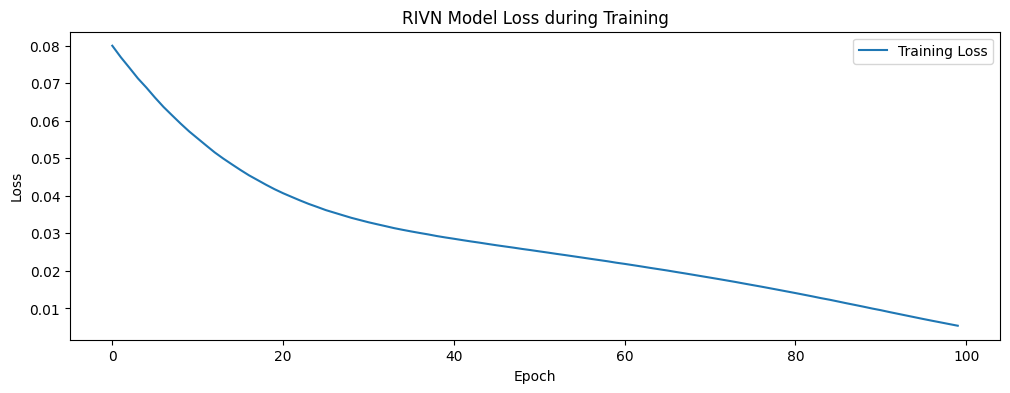

In [32]:
# Visualize the training loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'])
plt.title('RIVN Model Loss during Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

A downward trend in the loss plot would be indicative of model convergence.

In [28]:
# Get the models predicted price values 
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)
y_train_unscaled = dataset[10:training_data_len, :]

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((train_predictions - y_train_unscaled) ** 2)))
print('train rmse: ',rmse)

13/13 [==============================] - 1s 2ms/step
train rmse:  11.374459503043784


In [29]:
# Create the testing data set
test_data = scaled_data[training_data_len - 10: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('test rmse: ',rmse)

4/4 [==============================] - 0s 2ms/step
test rmse:  6.715671925983725


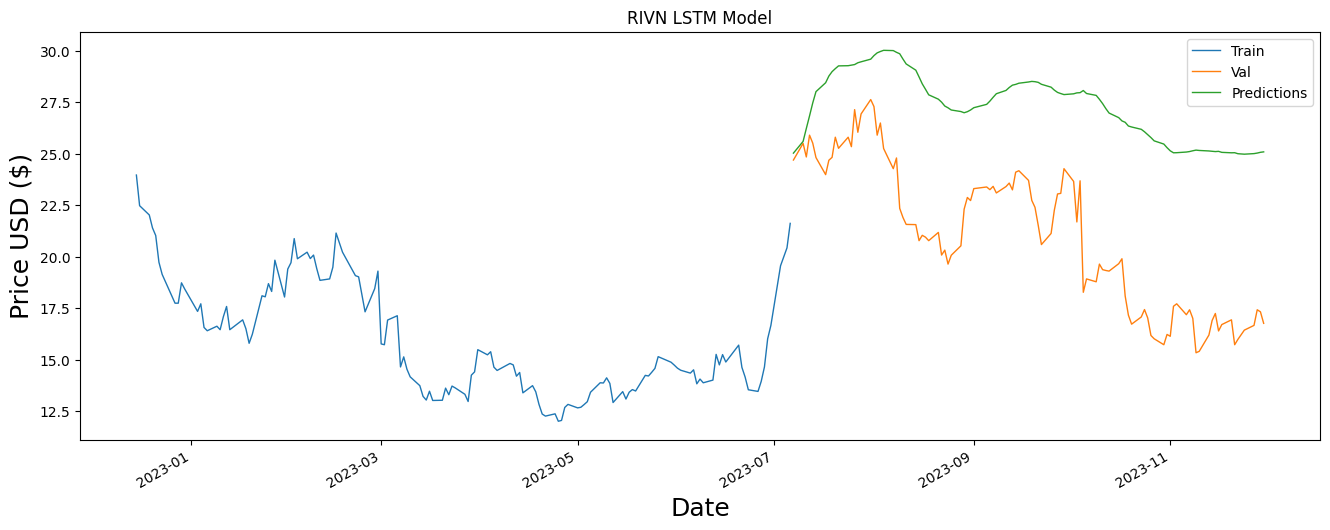

In [31]:
data = df_tsla.to_frame(name='price')

train = data[int(training_data_len/3*2):training_data_len]
valid = data[training_data_len:]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

train.index = pd.to_datetime(train.index)
valid.index = pd.to_datetime(valid.index)

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('RIVN LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(train['price'], linewidth=1)
plt.plot(valid[['price', 'Predictions']], linewidth=1)
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.gcf().autofmt_xdate()
plt.show()